# Simple comparison between Tikhonov and TV

In [1]:
import numpy as np
import scipy.io as sio


import F2O.F2O_utils as F2O
import F2O.constants as f2oDef
from F2O.imgUtils.image_utils import ImgMetrics, ImgPlot, ImgRead, ImgApplyFwNoise

from F2O.fwOp.fwOperator import fwOp, fwOp_f, conv2DOp

from F2O.noise.noiseModels import noiseModels

from F2O.PG_sptl import apg as APG


import multiprocessing
import pyfftw

pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#

No module named 'pyopencl'. cl12 version by Christoph Gohlke for windows is recommended: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyopencl


## Load test images

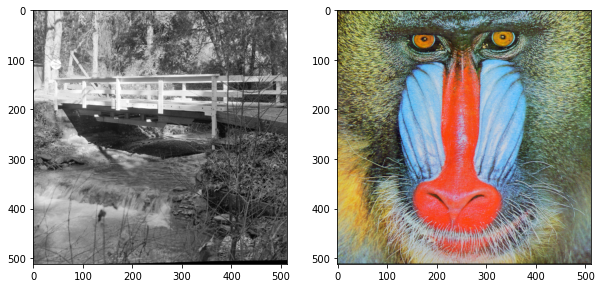

In [2]:
# -------------------
# --- Read images ---
# -------------------

import requests
from io import BytesIO

# Read images (images must be of the same size)
testImgs = ImgRead(enableJAX=False)

# Test images from the SIPI image database
fname = {0: requests.get('http://sipi.usc.edu/database/misc/5.2.10.tiff'),   # bridge (grayscale)
         1: requests.get('http://sipi.usc.edu/database/misc/boat.512.tiff'), # boat (grayscale)
         2: requests.get('http://sipi.usc.edu/database/misc/4.2.03.tiff'),   # mandrill (color)
         3: requests.get('http://sipi.usc.edu/database/misc/4.2.05.tiff'),   # airplane (color)
         4: requests.get('http://sipi.usc.edu/database/misc/4.2.07.tiff'),   # peppers (color)
        }

testImgs = ImgRead(enableJAX=False)        # If JAX is installed but just want to use 
                                           # standard numpy, then we need to pass this flag (once)

testImgs.list.append([BytesIO(fname.get(0).content),'g'])
testImgs.list.append([BytesIO(fname.get(2).content),'c'])
  

u = testImgs.readListImgs()                  # read list of images, normalize them between 0 and 1
                                             # u   : original image
                                             # obs : u corrupted with noise (depends on noiseModels)

        
pltImg  = ImgPlot()
pltImg.plotNImgs(u, len(u), None, 5)    



## Set the forward operator (conv). Define blurring filters

In [3]:
# Generate blurring filters
blurFilt = conv2DOp()

H = []

H.append( blurFilt.gauss2D((5,5), 2.5) )
H.append( blurFilt.average((5,5)) )


# Set forward op
Op = []
  
#Op.append( fwOp(linOp=f2oDef.fAx.conv2D, A=H[0]) )             
Op.append( fwOp(linOp=f2oDef.fAx.Identity) )             
Op[0].label     = 'Gaussian'
Op[0].padFlag   = True            # pad input image
Op[0].boundary  = 'symm'          # use symmetric boundary conditions
Op[0].mode      = 'same'          # output (convolution) has the same size as input
Op[0].vecFlag   = True           # input / output data are asumed / forced to be vectorized


Op.append( fwOp(linOp=f2oDef.fAx.conv2D, A=H[1]) )             
Op[1].label     = 'Average'
Op[1].padFlag   = True            # 
Op[1].boundary  = 'symm'          # 
Op[1].mode      = 'same'          # 
Op[1].vecFlag   = True           # 



## Observed images

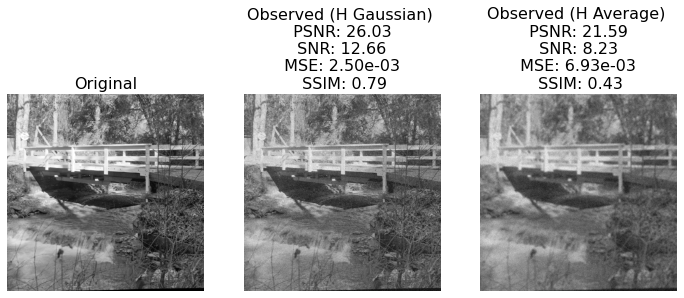

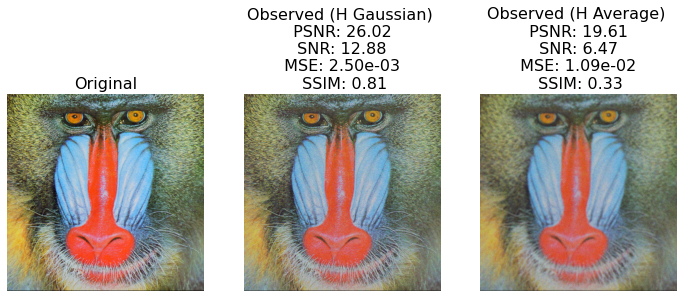

In [4]:
# --------------------------------------
# --- Set parameters for noise model ---
# --------------------------------------
    
sigma = 0.05
noise = noiseModels()

if sigma > 0:
    noise.model = f2oDef.noise.Gaussian
    noise.mean  = 0.
    noise.sigma = sigma

else:
    noise.model = f2oDef.noise.Null


# --------------------------------------
# --- Apply forward model plus noise ---
# --------------------------------------

applyModel = ImgApplyFwNoise(u, Op, noise)  # Applies the model to all images using all Op
                                            # in u. NOTE: u can be
                                            # * a data array
                                            # * a list of data arrays

applyModel.computeMetrics = True            # This option is handy when performing comparisons
applyModel.displayImgs    = True

b, metrics, pltImg = applyModel.obsImg()    # b is a list
                                            # b[k][n] : k <--> index for images
                                            #           n <--> index for Op

for k in range(len(u)):
      pltImg.plotNImgs(pltImg.imgShow[k], len(Op)+1, pltImg.txtN[k])


## Define opt problem

In [14]:
# --------------------------------------
# Define parameter optimization variable 
# --------------------------------------

args = F2O.argsF2O()
  
args.verbose    = True
args.fCostClass = f2oDef.cost.L2TV_lin      # f(x) = 0.5|| fAx(x) - b ||_2^2 + \lambda|| \nabla x ||_1, 
                                            #        where fAx is lineal

args.ssPolicy = f2oDef.ss.dualTV 

args.freqSol         = False
args.padFlag         = True
args.padMode         = 'symmetric' 

# Optional: Add a callback routine. It will be executed every args.verboseStep (default 10) iterations
recMetrics    = ImgMetrics()
args.callback = lambda  x : recMetrics.psnr(u[k],x)


## Deconvolution

In [15]:

# select image and blur

k = { 'bridge':   0,  # grayscale
      'boats':    1,  # grayscale
      'mandrill': 2,  # color
    }.get('bridge')

n = 0  # operator

lmbda = 0.05
nIter = 50             

sol   = APG(Op[n], b[k][n], lmbda, nIter, args)

xRec = np.clip(sol[0], 0., 1.)




Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 3.412e+04	 2.50e+00    5.66e-02    nan
 10	 3.210e+04	 2.50e+00    5.17e-01    4.378e-02
 20	 3.208e+04	 2.50e+00    9.65e-01    1.552e-02
 30	 3.208e+04	 2.50e+00    1.42e+00    7.673e-03
 40	 3.208e+04	 2.50e+00    1.86e+00    4.493e-03
 49	 3.208e+04	 2.50e+00    2.27e+00    3.041e-03


array([28.78041023,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       27.48427669,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       27.48775742,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       27.48447997,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       27.48328549,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 27.48258292])